# Format Results

In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
def get_results(exp_name, df_og):
    folder = exp_name
    files = os.listdir(folder)
    files = [f for f in files if re.match(r".*\.csv", f)]
    df = pd.DataFrame()
    for f in files:
        pth = os.path.join(folder, f)
        tmp = pd.read_csv(pth)
        # replace "Method" column with layer.#
        step_num = tmp['Method'].values[0].split("_")[3].split("-")[1]
        lr = tmp['Method'].values[0].split("_")[5]
        epoch = tmp['Method'].values[0].split("_")[6]
        tofu_size = exp_name.split('/')[3]
        if tofu_size == 'tofu':
            tofu_size = 'tofu-4000'
        tmp['Step'] = step_num
        tmp['lr'] = lr
        tmp['epoch'] = epoch
        tmp['tofu_size'] = tofu_size
        df = pd.concat([df, tmp])

    # add a df_og row for each layer
    if df_og is not None:
        tofu_size = df['tofu_size'].unique()
        df_full_duplicated = pd.DataFrame([df_og.iloc[0]] * len(tofu_size))
        df_full_duplicated['tofu_size'] = tofu_size
        df_full_duplicated['Step'] = 0
        df_full_duplicated['epoch'] = df['epoch'].unique()[0]
        df = pd.concat([df, df_full_duplicated], ignore_index=True)

    df['Avg Synthetic'] = (df['ROUGE Retain'] + df['ROUGE Forget']) / 2
    df['Avg Real World'] = (df['ROUGE Real Authors'] + df['ROUGE Real World']) / 2

    # sort
    df['Step'] = df['Step'].astype(int)
    df['lr_float'] = df['lr'].astype(float)
    df['epoch'] = df['epoch'].astype(int)
    df = df.sort_values(by=['epoch', 'lr_float', 'Step']).reset_index(drop=True)
    df = df.drop(columns=['lr_float'])
    return df

In [4]:
og_results = "workspace/FiLLM/results/tofu/qwen2-1.5b_OG_tofu_forget01_perturbed.csv"
# og_results = "results/tofu/qwen2-1.5b_OG_forget01_perturbed.csv"
df_og = pd.read_csv(og_results)

In [28]:
results = [
    # "workspace/FiLLM/results/tofu/finetune_over_time_10",
    "workspace/FiLLM/results/tofu/finetune_tofu4000_10",
    "workspace/FiLLM/results/tofu-1600/finetune_tofu1600_10",
    # "knowundo-copyright/finetune_over_time_15",
]
checkpoint_step = 125 # tofu
# checkpoint_step = 62 # knowundo
results_df = pd.concat([get_results(r, df_og) for r in results])
len(results_df)

22

In [6]:
palette = sns.color_palette("tab20", 3) # hls, husl, coolwarm, tab20
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

In [7]:
def best_step(experiment):
    # find the closest step to the ideal values
    df = experiment
    avg_rouge = (df['Avg Synthetic'] + df['Avg Real World']) / 2

    idx = avg_rouge.idxmax()
    return int(df.loc[idx]['Step'])

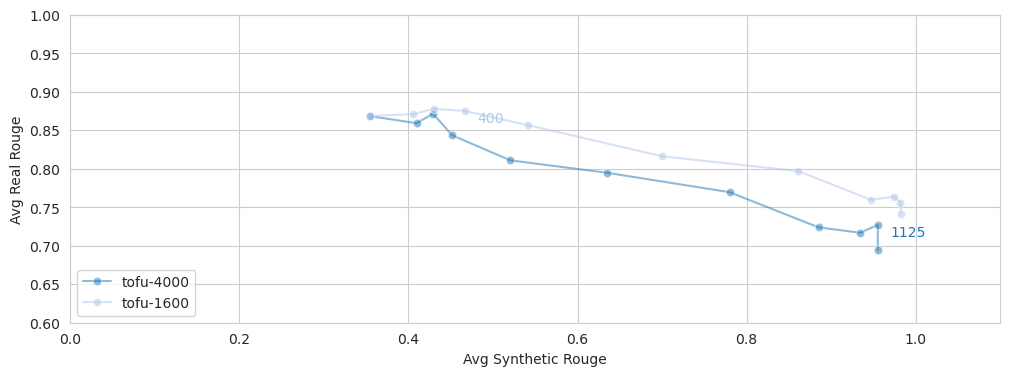

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))

alpha = 0.5
palette = sns.color_palette("tab20", len(results_df.drop_duplicates(subset=['lr', 'epoch']))) # hls, husl, coolwarm, tab20

for i, (tofu_size, epoch) in enumerate(results_df.drop_duplicates(subset=['tofu_size', 'epoch'])[['tofu_size', 'epoch']].values):
    layer_df = results_df[(results_df['tofu_size'] == tofu_size) & (results_df['epoch'] == epoch)].reset_index(drop=True)
    color = palette[i]
    sns.lineplot(x="Avg Synthetic", y="Avg Real World", data=layer_df, ax=ax, marker="o", c=color, alpha=alpha, label=f"{tofu_size}")
    step = best_step(layer_df)
    text_x = layer_df["Avg Synthetic"][step//checkpoint_step-1] + 0.015
    text_y = layer_df["Avg Real World"][step//checkpoint_step-1] - 0.015
    ax.annotate(f"{step}", (text_x, text_y), fontsize=10, color=palette[i], alpha=1, clip_on=True, zorder=2)

ax.set_xlabel("Avg Synthetic Rouge")
ax.set_ylabel("Avg Real Rouge")

plt.xlim(0, 1.1)
plt.ylim(0.6, 1)
plt.legend(loc='lower left')

# plt.xlim(0.55, 0.35)
# plt.ylim(0.8, 1)
# plt.legend(loc='lower right')

# plt.xlim(1, 0)
# plt.ylim(0, 1)

plt.show()

# save
# fig.savefig("figures/knowundo_lr_comparison.svg", format="svg")

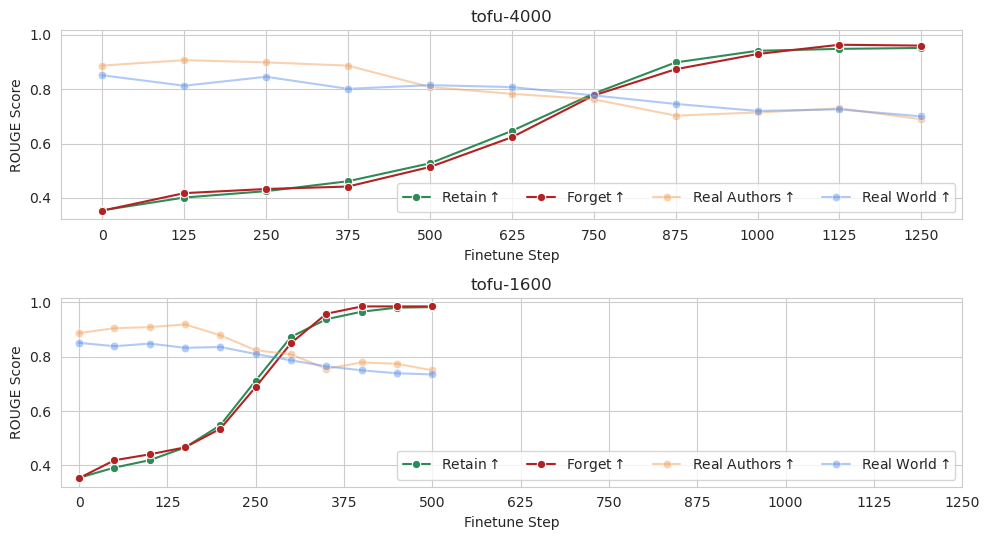

In [33]:
# plot each layer on the x axis and both the retain rouge and forget rouge on the y axis
sns.set_style(style="whitegrid")

num_plots = len(results_df['tofu_size'].unique())
fig, axs = plt.subplots(num_plots, 1, figsize=(10, num_plots*2.75), sharex=False, sharey=True)

for i, ax in enumerate(axs.flat):
    tofu_size = results_df['tofu_size'].unique()[i]
    df_ = results_df[results_df['tofu_size'] == tofu_size].reset_index(drop=True)

    sns.lineplot(x="Step", y="ROUGE Retain", data=df_, ax=ax, marker="o", label="Retain$\\uparrow$", c="seagreen", alpha=1)
    sns.lineplot(x="Step", y="ROUGE Forget", data=df_, ax=ax, marker="o", label="Forget$\\uparrow$", c="firebrick", alpha=1)
    sns.lineplot(x="Step", y="ROUGE Real Authors", data=df_, ax=ax, marker="o", label="Real Authors$\\uparrow$", c="sandybrown", alpha=0.5)
    sns.lineplot(x="Step", y="ROUGE Real World", data=df_, ax=ax, marker="o", label="Real World$\\uparrow$", c="cornflowerblue", alpha=0.5)

    #change x axis name
    ax.set_xlabel("Finetune Step")
    ax.set_ylabel("ROUGE Score")

    # ticks = int(tofu_size.split("-")[1]) // 32
    # ax.set_xticks(np.arange(0, ticks*10+1, ticks))
    ax.set_xticks(np.arange(0, 1251, 125))

    ax.set_title(f"{tofu_size}")

    ax.legend(loc='lower right', ncols=4)

plt.tight_layout()
plt.show()

# save figure as svg
# fig.savefig(f"figures/knowundo_ft_lr_charts.svg", format="svg")
# fig.savefig(f"figures/tofu_ft_lr_charts.svg", format="svg")